# Analysis file for Ariane quantitative runs
gets data from .nc file into basic plot<br>
based on code from https://github.com/SalishSeaCast/analysis-susan/blob/master/notebooks/Ariane/FluxRobertsBankApr2015-New.ipynb

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from dateutil.relativedelta import relativedelta

%matplotlib inline
# plt.rcParams['font.size'] = 18

### lets get % of flow to each CS month to month for the full 5 years

In [3]:
def get_transport(mydata, section, starttime, endtime):
    time = endtime-starttime+1
    transports = (mydata.final_transp[(mydata.final_section==section) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)])/time
    sumTr = sum(transports)
    
    transports = (mydata.final_transp[(mydata.final_section != 0) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)])/time
    totalTr = sum(transports)
    return sumTr, totalTr

In [4]:
yearjumps = [0,1,-2,1,0,1,0,1,1,0,1,0]
str_mo = ['jan', 'feb', 'mar', 'apr','may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
starttime = 1
endtime = 720
time = endtime-starttime+1

sec_nums = [2,3,4,5,6]
admiralty = np.array([])
deception = np.array([])
rosario = np.array([])
sanjuan = np.array([])
haro = np.array([])
sections = [admiralty, deception, rosario, sanjuan, haro]
all_total = np.array([])

#2016 and 2017
year = [16,17]

for num in year:
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan'+str(num)+'/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)
    for i in range(12):
        for j in range(len(sec_nums)):
            temp, totalT = get_transport(mydata, sec_nums[j], starttime+(i*720+(sum(yearjumps[:i+1]*24))), endtime+(i*720+(sum(yearjumps[:i+1]*24))))
            sections[j] = np.append(sections[j],temp)
        all_total = np.append(all_total, totalT)

#2019 and 2018 (both done month by month)
year = [18,19]
for num in year:
    for i in range(len(str_mo)):
        file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_1hr/forward_01'+str_mo[i]+str(num)+'/ariane_positions_quantitative.nc'
        mydata = xr.open_dataset(file)
        time = mydata.init_t[-1]

        totalT = sum((mydata.final_transp[(mydata.final_section != 0) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)])/time)

        for j in range(len(sec_nums)):
            temp = sum((mydata.final_transp[(mydata.final_section==sec_nums[j]) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)])/time)
            sections[j] = np.append(sections[j],temp)       
        all_total = np.append(all_total, totalT)
            
#2020
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan20/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
for i in range(12):
    for j in range(len(sec_nums)):
        temp, totalT = get_transport(mydata, sec_nums[j], starttime+(i*720+(sum(yearjumps[:i+1]*24))), endtime+(i*720+(sum(yearjumps[:i+1]*24))))
        sections[j] = np.append(sections[j],temp)
    all_total = np.append(all_total, totalT)

In [5]:
admiralty = sections[0]
deception = sections[1]
rosario = sections[2]
sanjuan = sections[3]
haro = sections[4]

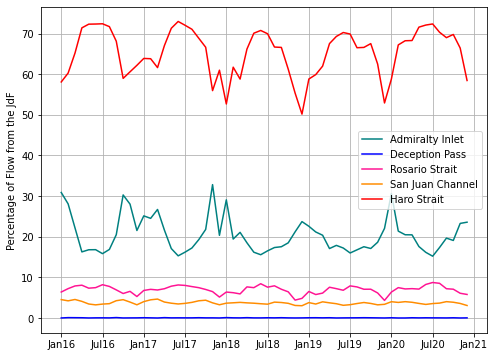

In [6]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))
ax.plot(admiralty/all_total*100, c='teal',label="Admiralty Inlet")
ax.plot(deception/all_total*100, c='b',label="Deception Pass")
ax.plot(rosario/all_total*100, c='deeppink',label="Rosario Strait")
ax.plot(sanjuan/all_total*100, c='darkorange', label="San Juan Channel")
ax.plot(haro/all_total*100, c='r',label="Haro Strait")
ax.legend()
ax.set_ylabel("Percentage of Flow from the JdF")
# ax.set_xlabel("Month")
ax.set_xticks(np.arange(0,61,6))
ax.set_xticklabels(['Jan16','Jul16','Jan17','Jul17','Jan18','Jul18','Jan19','Jul19','Jan20','Jul20','Jan21'])
ax.grid()

In [8]:
print("haro average = "+str(sum(haro)/len(haro)))
print("rosario average = "+str(sum(rosario)/len(rosario)))
print("sanjuan average = "+str(sum(sanjuan)/len(sanjuan)))

print("admiralty average = "+str(sum(admiralty)/len(admiralty)))
print("deception average = "+str(sum(deception)/len(deception)))

print('SoG average = '+str((sum(haro)+sum(rosario)+sum(sanjuan))/len(haro)))
print('Puget average = '+str((sum(admiralty)+sum(deception))/len(haro)))

haro average = 47043.53629694011
rosario average = 5059.256530137992
sanjuan average = 2621.0124974082623
admiralty average = 13583.884002511168
deception average = 53.380141421131825
SoG average = 54723.80532448636
Puget average = 13637.2641439323


In [9]:
# (sum(haro[12:24])+sum(rosario[12:24])+sum(deception[12:24]))/12
print('SoG 2017 average = '+str((sum(haro[12:24])+sum(rosario[12:24])+sum(sanjuan[12:24]))/12))
print('Puget 2017 average = '+str((sum(admiralty[12:24])+sum(deception[12:24]))/12))

SoG 2017 average = 55788.09422595443
Puget 2017 average = 14265.766659171655


In [7]:
haro

array([21607.62935578, 30937.59524706, 28608.17327696, 49721.44876697,
       66819.99343723, 66302.99103956, 70196.42032056, 79090.53886138,
       61630.66308424, 21341.85400949, 16339.42762823, 35184.51990547,
       35331.51596407, 38619.53594129, 25406.74443193, 32898.6926534 ,
       58357.75431197, 68158.18796724, 77729.01432585, 71613.22684731,
       58785.61575529, 47916.5094692 , 19427.86803411, 39905.75970759,
       15650.87234754, 50255.08326631, 29717.4233556 , 36838.9611538 ,
       57870.34664285, 63706.62063013, 71878.01084082, 66604.31005884,
       50008.67309795, 42510.0442919 , 27515.29536726, 21034.9305333 ,
       25988.11579935, 44439.64786478, 36475.45953552, 42677.69863715,
       56830.41150181, 65567.50342235, 64231.84484938, 65599.82631522,
       50008.67309795, 53832.0337157 , 53301.70628165, 28271.86374852,
       20319.08534126, 43231.51673003, 44866.69420934, 52445.89368077,
       39813.96476777, 62963.94500828, 73108.37180078, 71666.02085979,
      

In [10]:
(rosario)

array([2387.49001419, 3723.87093994, 3472.68064629, 5640.11049156,
       6807.56596248, 6872.25352587, 7967.65460469, 8599.73088947,
       6285.33223482, 2191.05539624, 1776.22311846, 3006.79684648,
       3766.01825372, 4285.18182254, 2852.9682546 , 3549.09303616,
       6431.16426147, 7620.59676903, 8682.99016318, 7819.18595309,
       6395.03484339, 5068.86092417, 2263.6926743 , 3386.19902361,
       1905.53013932, 5092.24171374, 3009.69090995, 4275.9750624 ,
       6188.67974919, 7618.84281853, 7823.45364221, 7938.24349568,
       5332.71196608, 4488.74163837, 2202.23597604, 2038.25780753,
       2896.50653355, 4304.20389664, 3622.19543851, 4802.90323273,
       5945.20031901, 6396.92990689, 7292.74848314, 7568.94118679,
       5332.71196608, 5670.00964682, 5279.01424832, 2327.6755515 ,
       2215.21495635, 4825.58948974, 4720.84857417, 5570.38186868,
       3972.11206194, 7234.25998413, 8853.32941008, 8726.12800025,
       5925.51630387, 5446.33832881, 3248.68500762, 2611.59184

In [13]:
HR = np.array(haro)+np.array(rosario)+np.array(sanjuan)

In [14]:
HR

array([25689.39939365, 36844.91100371, 34093.11954682, 58232.68955965,
       76836.37256331, 76165.24248805, 81511.83302528, 91612.61835142,
       71793.16581451, 25176.53559366, 19180.40129272, 40045.92777005,
       41343.03544212, 45631.43654991, 30192.28255858, 38388.29733113,
       67792.98658048, 79028.33150307, 90326.7649718 , 83338.19530142,
       68822.99624243, 56156.12148201, 22995.8686358 , 45440.81411272,
       18649.18782522, 58416.95851786, 34684.50341697, 43204.63023617,
       67088.94619439, 74512.42990656, 83224.71734446, 78474.79127285,
       58226.23297974, 49527.07038057, 31265.34759773, 24351.84316615,
       30571.27926998, 51316.59410885, 42457.27781173, 49858.13048918,
       65681.2009394 , 74908.67263439, 74560.34428822, 76710.33828706,
       58226.23297974, 62380.74804275, 61368.5594016 , 32413.33161383,
       23928.14632653, 50542.28786336, 52249.46526033, 61009.18737177,
       45798.64174814, 73142.33769887, 85580.6702885 , 84155.41232484,
      

In [15]:
# overall summer average
#april:sep, may:oct, mar:sep, apr:nov, mar:oct
#3:9, 4+12:10+12, 2+12*2:9+12*2, 3*12*3:11+12*3, 2+12*4:10*12*4 
num_mo = 30
HR = np.array(haro)+np.array(rosario)+np.array(sanjuan)
print(np.sum([np.sum(HR[3:9]),np.sum(HR[4+12:10+12]),np.sum(HR[2+12*2:9+12*2]),np.sum(HR[3*12*3:11+12*3]),np.sum(HR[2+12*4:10*12*4])])/num_mo)

PS = np.array(admiralty)+np.array(sanjuan)
print(np.sum([np.sum(PS[3:9]),np.sum(PS[4+12:10+12]),np.sum(PS[2+12*2:9+12*2]),np.sum(PS[3*12*3:11+12*3]),np.sum(PS[2+12*4:10*12*4])])/num_mo)

64709.0912898056
17183.659252539073


In [11]:
months=np.array([pd.to_datetime(pd.to_datetime('2016-1-1') + relativedelta(months=i)) for i in range(60)])

In [10]:
season = [pd.to_datetime('2016-04-01'), pd.to_datetime('2016-09-01'),
 pd.to_datetime('2017-05-01'),pd.to_datetime('2017-10-01'),
 pd.to_datetime('2018-03-01'),pd.to_datetime('2018-09-01'),
 pd.to_datetime('2019-04-01'),pd.to_datetime('2019-11-01'),
 pd.to_datetime('2020-03-01'),pd.to_datetime('2020-10-01')]

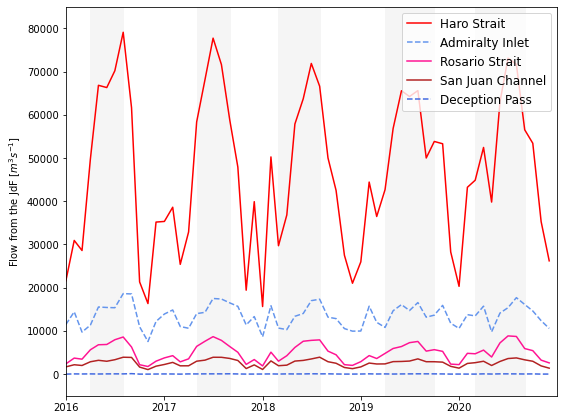

In [12]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))

plt.rcParams['font.size'] = 12

ax.plot(months,haro, c='r', label="Haro Strait")
ax.plot(months,admiralty, c='cornflowerblue',label="Admiralty Inlet",linestyle='dashed')
ax.plot(months,rosario, c='deeppink',label="Rosario Strait")
ax.plot(months,sanjuan, c='firebrick', label="San Juan Channel")
ax.plot(months,deception, c='royalblue',label="Deception Pass",linestyle='dashed')

ax.legend(loc="upper right",fontsize=12)
ax.set_ylabel("Flow from the JdF [$m^{3}s^{-1}$]")
ax.set_xticks(np.array([pd.to_datetime(pd.to_datetime('2016-1-1') + relativedelta(months=i*12)) for i in range(6)]))
ax.set_xticklabels(['2016','2017','2018','2019','2020','2021'])#,fontsize=14)
ax.set_ylim(-5000,85000)
ax.set_xlim(pd.to_datetime('2016-01-01'),pd.to_datetime('2020-12-31'))

# season = np.array([pd.to_datetime(pd.to_datetime('2016-04-01') + relativedelta(months=6*i)) for i in range(10)])
for i in range(0, len(season),2):
    ax.fill_between(months, -5000, 85000, where=(months<season[i+1])&(months>=season[i]), color='whitesmoke')
plt.tight_layout()
plt.savefig("./figures/channelFlow.pdf")

In [6]:
print(np.max(rosario))
print(np.max(sanjuan))
print(np.max(deception))

8853.32941008445
3932.237718326156
126.11675874224515


In [28]:
# residence time of SoG and Puget based on volume of these basins?
V_pug = 168*(1000**3) # km3 converted to m3, easily found online
V_sog = 222000*28000*155 #couldn't find quickly nad decided not to bother, based on average width, length, and depth from Thomson 1981

(-1.0, 61.0)

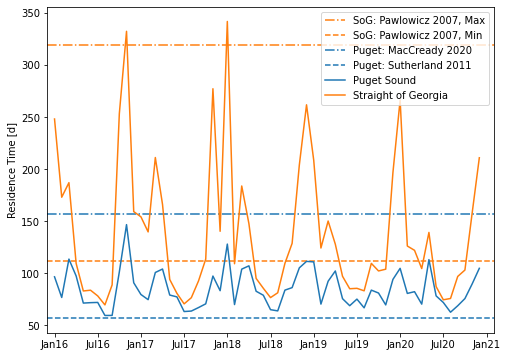

In [29]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))
ax.plot([-1,61],[319,319], c='tab:orange',  linestyle='-.',label="SoG: Pawlowicz 2007, Max")
ax.plot([-1,61],[112,112], c='tab:orange', linestyle='--',label="SoG: Pawlowicz 2007, Min")
ax.plot([-1,61],[157,157], c='tab:blue', linestyle='-.',label="Puget: MacCready 2020")
ax.plot([-1,61],[57,57], c='tab:blue', linestyle='--',label="Puget: Sutherland 2011")
ax.plot((V_pug/(admiralty+deception))/(60*60*42), c='tab:blue',label="Puget Sound")
ax.plot((V_sog/(haro+sanjuan+rosario))/(60*60*42), c='tab:orange',label="Straight of Georgia")
ax.legend()
ax.set_ylabel("Residence Time [d]")
# ax.set_xlabel("Month")
ax.set_xticks(np.arange(0,61,6))
ax.set_xticklabels(['Jan16','Jul16','Jan17','Jul17','Jan18','Jul18','Jan19','Jul19','Jan20','Jul20','Jan21'])
# ax.grid()
ax.set_xlim([-1,61])

not wild compared to previous estiamtions of the residence time of the SoG (112-319 in Pawlowicz 2007) or Puget (57 in Sutherland 2011 and 157 in MacCready 2020)